<a href="https://colab.research.google.com/github/OmarAmeer96/Wheel-n-Deal/blob/AI/comment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [2]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [3]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

 78% 41.0M/52.6M [00:00<00:00, 99.3MB/s]
100% 52.6M/52.6M [00:00<00:00, 102MB/s] 


In [5]:
!unzip -j jigsaw-toxic-comment-classification-challenge.zip
!unzip -j train.csv.zip
!unzip -j test.csv.zip
!unzip -j test_labels.csv.zip


Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         


load data

In [6]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')

In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [9]:
test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [10]:
merged = test.merge(test_labels, on='id', how='left')
merged.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,":If you have a look back at the source, the in...",-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,I don't anonymously edit articles at all.,-1,-1,-1,-1,-1,-1


In [11]:
import pandas as pd
full_data = pd.concat([train, test], axis=0, ignore_index=True)
full_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0.0,0.0,0.0,0.0,0.0,0.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0.0,0.0,0.0,0.0,0.0,0.0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0.0,0.0,0.0,0.0,0.0,0.0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0.0,0.0,0.0,0.0,0.0,0.0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
full_data.dropna(inplace= True)

In [13]:
full_data.shape, train.shape, test.shape

((159571, 8), (159571, 8), (153164, 2))

In [14]:
X = full_data.iloc[:, 1].values
X.shape

(159571,)

In [15]:
y = full_data.iloc[:, 2:].values
y.shape

(159571, 6)

In [16]:

max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X))
list_tokenized_train = tokenizer.texts_to_sequences(X)

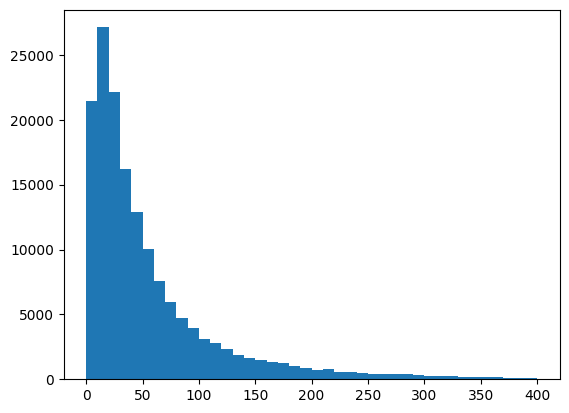

In [17]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [18]:
maxlen = 200
X = pad_sequences(list_tokenized_train, maxlen=maxlen)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

In [20]:
inp = Input(shape=(maxlen, ))

In [21]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [22]:
x = LSTM(60,name='lstm_layer')(x)

In [23]:
x = Dropout(0.1)(x)

In [24]:
x = Dense(50, activation="relu")(x)

In [25]:
x = Dropout(0.1)(x)

In [26]:
x = Dense(6, activation="sigmoid")(x)

In [27]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

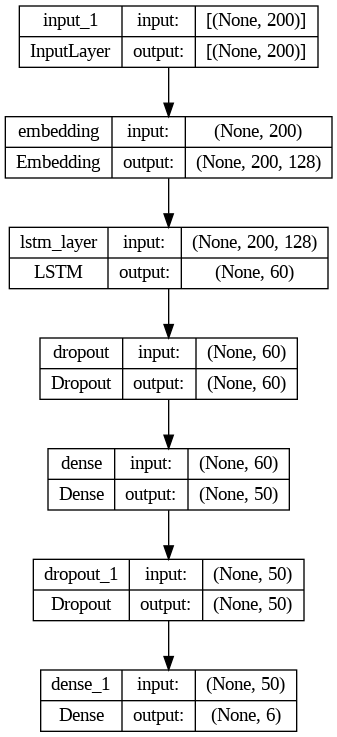

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 60)                45360     
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 306   

In [30]:
batch_size = 32
epochs = 2
model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/2
3192/3192 [==============================] - 669s 209ms/step - loss: 0.0716 - accuracy: 0.9366 - val_loss: 0.0530 - val_accuracy: 0.9943
Epoch 2/2
3192/3192 [==============================] - 673s 211ms/step - loss: 0.0466 - accuracy: 0.9879 - val_loss: 0.0497 - val_accuracy: 0.9943


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 200, 128)          2560000   
                                                                 
 lstm_layer (LSTM)           (None, 60)                45360     
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3050      
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 306 

In [ ]:
t = tokenizer.texts_to_sequences([
        "you're fool",
        "you are freaking stupid",
        "it was so great to deal with you",
        "thanks good job"
    ])

In [ ]:
t = pad_sequences(t, maxlen=maxlen)

In [ ]:
model.predict(t)

1/1 [==============================] - 0s 43ms/step


array([[9.22903419e-01, 4.47954386e-02, 4.70975935e-01, 2.62027439e-02,
        5.72794080e-01, 8.87934566e-02],
       [9.97300863e-01, 1.13454595e-01, 9.21192944e-01, 6.53611822e-03,
        7.88345218e-01, 5.73441759e-02],
       [1.72262769e-02, 2.82140772e-05, 1.61964423e-03, 2.41189555e-04,
        2.43733078e-03, 9.67047701e-04],
       [2.43582763e-03, 2.76255560e-06, 2.92565615e-04, 3.01910422e-05,
        2.85872578e-04, 1.90193954e-04]], dtype=float32)

In [31]:
results = model.evaluate(X_test, y_test)
print(results)

998/998 [==============================] - 43s 43ms/step - loss: 0.0488 - accuracy: 0.9940
[0.04876015707850456, 0.994046688079834]


In [ ]:
!mkdir -p saved_model

model.save('saved_model/toxic_comments.h5')

import pickle
with open('saved_model/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!zip -r saved_model.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/toxic_comments.h5 (deflated 5%)
  adding: saved_model/tokenizer.pkl (deflated 59%)
